# Evaluation of 2 Models

In [165]:
model_1 = "pix2pix_1_0"
model_1_type = "pix2pix"
model_2 = "pix2pix_1_0_wgangp"
model_2_type = "pix2pix"

data_1 = "../../data/nms1000_test_1_0_2500_2500"
data_1_type = "physgen"
data_2 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_2_type = "physgen"
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined

different_naming_1 = False
different_naming_2 = False

batch_size = 18
data_to_process_size = "inf"
image_size = 256

### Env Setup

In [2]:
!conda create -n eval python=3.8 -y
!conda activate eval

Retrieving notices: ...working... done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/tippolit/anaconda3/envs/eval

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2025.2.25-h06a4308_0 
  ld_impl_linux-64   pkgs/main/linux-64::ld_impl_linux-64-2.40-h12ee557_0 
  libffi             pkgs/main/linux-64::libffi-3.4.4-h6a678d5_1 
  libgcc-ng          pkgs/main/linux-64::libgcc-ng-11.2.0-h1234567_1 
  libgomp            pkgs/main/linux-64::libgomp-11.2.0-h1234567_1 
  libstdcxx-ng       pkgs/main/linux-64::libstdcxx-ng-11.2.0-h1234567_1 
  ncurses            pkgs/main/linux-64::ncurses-6.4-h6a678d5_0 
  openssl            pkgs/main/linux-64::openssl-3.0.16-h5eee18b_0 
  pip                pkgs/m

Activate now eval env and run:

In [ ]:
!pip install pandas
!pip install ipython
!pip install ipykernel
!pip install opencv-python
!pip install shapely
!pip install pytorch-msssim
!pip install scikit-image
!pip install -r requirements.txt

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Using cached ipython-8.12.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached backcall-0.2.

> Set 'eval' as your python env

### Imports

In [166]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [167]:
!python --version

Python 3.8.20


### Helper

In [168]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False, log=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    # print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    # print(f"Transformed shape to: {img_shape}")

    # get better look at reflections
    # mask = (img >= 200) & (img <= 240)
    # img[mask] -= 33
    # img = cv2.add(img, np.full(img.shape, 33, dtype=img.dtype))

    # Better distribution
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = normalized_img * (255)
    #img = cv2.equalizeHist(img)

    # invert images
    if invert:
        # print("Invert images...")
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    if log:
        img[img <= 0] = 1e-3
        # img = np.apply_along_axis(np.log, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        # print(f"Using '{plt_style}' plotting style.")

    # plotting
    # print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2] == 3:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            # print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        if log:
            cur_ax.imshow(cur_img, cmap=used_cmap, norm=LogNorm())
        else:
            cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False, log=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    elif color_space.lower() in ["grey", "gray", "g"]:
        images = np.array([cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths])
        images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert, log=log)
    return images

### Run Tests

In [169]:
command = (
  f"python test.py "
  f"--dataroot {data_1} "
  f"--name {model_1} "
  f"--model {model_1_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_1_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_1} "
  f"--phase test "
  f"--eval"
)

if different_naming_1:
  command += " --different_building_naming"

if data_1_type == "physgen":
  command += f" --variation {physgen_variation}"

# Finally run it
!{command}

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500	[default: None]
             dataset_mode: physgen                       	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                         	[de

processing (0125)-th image... ['./cache_physgen/building_125.png']
processing (0130)-th image... ['./cache_physgen/building_130.png']
processing (0135)-th image... ['./cache_physgen/building_135.png']
processing (0140)-th image... ['./cache_physgen/building_140.png']
processing (0145)-th image... ['./cache_physgen/building_145.png']
processing (0150)-th image... ['./cache_physgen/building_150.png']
processing (0155)-th image... ['./cache_physgen/building_155.png']
processing (0160)-th image... ['./cache_physgen/building_160.png']
processing (0165)-th image... ['./cache_physgen/building_165.png']
processing (0170)-th image... ['./cache_physgen/building_170.png']
processing (0175)-th image... ['./cache_physgen/building_175.png']
processing (0180)-th image... ['./cache_physgen/building_180.png']
processing (0185)-th image... ['./cache_physgen/building_185.png']
processing (0190)-th image... ['./cache_physgen/building_190.png']
processing (0195)-th image... ['./cache_physgen/building_195.p

In [170]:
command = (
  f"python test.py "
  f"--dataroot {data_2} "
  f"--name {model_2} "
  f"--model {model_2_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_2_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_2} "
  f"--phase test "
  f"--eval"
)

if different_naming_2:
  command += " --different_building_naming"

if data_2_type == "physgen":
  command += f" --variation {physgen_variation}"

# Run it
!{command}


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 18                            	[default: 1]
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: physgen                       	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                  

processing (0115)-th image... ['./cache_physgen/building_115.png']
processing (0120)-th image... ['./cache_physgen/building_120.png']
processing (0125)-th image... ['./cache_physgen/building_125.png']
processing (0130)-th image... ['./cache_physgen/building_130.png']
processing (0135)-th image... ['./cache_physgen/building_135.png']
processing (0140)-th image... ['./cache_physgen/building_140.png']
processing (0145)-th image... ['./cache_physgen/building_145.png']
processing (0150)-th image... ['./cache_physgen/building_150.png']
processing (0155)-th image... ['./cache_physgen/building_155.png']
processing (0160)-th image... ['./cache_physgen/building_160.png']
processing (0165)-th image... ['./cache_physgen/building_165.png']
processing (0170)-th image... ['./cache_physgen/building_170.png']
processing (0175)-th image... ['./cache_physgen/building_175.png']
processing (0180)-th image... ['./cache_physgen/building_180.png']
processing (0185)-th image... ['./cache_physgen/building_185.p

### Extract Test Predictions

In [171]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [172]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_990_real_B.png' to '../../data/eval/pix2pix_1_0/real/building_990.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_977_real_A.png' to '../../data/eval/pix2pix_1_0/osm/building_977.png'
[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_607_real_B.png' to '../../data/eval/pix2pix_1_0/real/building_607.png'
[info] copied real from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_216_real_B.png' to '../../data/eval/pix2pix_1_0/real/building_216.png'
[info] copied pred from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_568_fake_B.png' to '../../data/eval/pix2pix_1_0/pred/building_568.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/building_897_real_A.png' to '../../data/eval/pix2pix_1_0/osm/building_897.png'
[info] copied osm from './eval/pix2pix_1_0/pix2pix_1_0/test_latest/images/

In [173]:
evaluation_path = f"./eval/{model_2}/{model_2}/test_latest/images"
target_path = f"../../data/eval/{model_2}"

In [174]:
!python eval_extractor.py \
    --name {model_2} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_990_real_B.png' to '../../data/eval/pix2pix_1_0_wgangp/real/building_990.png'
[info] copied osm from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_977_real_A.png' to '../../data/eval/pix2pix_1_0_wgangp/osm/building_977.png'
[info] copied real from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_607_real_B.png' to '../../data/eval/pix2pix_1_0_wgangp/real/building_607.png'
[info] copied real from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_216_real_B.png' to '../../data/eval/pix2pix_1_0_wgangp/real/building_216.png'
[info] copied pred from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_568_fake_B.png' to '../../data/eval/pix2pix_1_0_wgangp/pred/building_568.png'
[info] copied osm from './eval/pix2pix_1_0_wgangp/pix2pix_1_0_wgangp/test_latest/images/building_897_real_A.png' to '../..

### Calc Eval metrics

In [175]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples:   7%|█▎                  | 146/2245 [00:03<00:47, 44.65it/s]

Evaluating samples:   9%|█▉                  | 211/2245 [00:05<00:45, 44.71it/s]Prediction for sample ._real.png not found.
../../data/eval/pix2pix_1_0/pred/._real.png
Evaluating samples: 100%|███████████████████| 2245/2245 [00:50<00:00, 44.11it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  2244.000000  2244.000000  ...  2244.000000  2244.000000
mean      4.099141    28.916187  ...    28.916361    17.588478
std       1.930146     7.994119  ...     7.994261    12.846804
min       0.805951     9.594426  ...     9.594243     0.000000
25%       2.577239    23.987855  ...    23.987931     5.102043
50%       3.547157    28.589964  ...    28.590189    15.887846
75%       5.610001    33.227831  ...    33.227930    30.210319
max      10.559780    63.855625  ...    63.856411    45.217392

[8 rows x 6 columns]


In [176]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_2}/real \
    --pred_dir ../../data/eval/{model_2}/pred \
    --osm_dir ../../data/eval/{model_2}/osm \
    --output ./eval_results/evaluation_{model_2}.csv

Evaluating samples:   9%|█▋                  | 106/1245 [00:02<00:26, 43.00it/s]Prediction for sample ._real.png not found.
../../data/eval/pix2pix_1_0_wgangp/pred/._real.png
Evaluating samples:  16%|███▏                | 202/1245 [00:04<00:24, 42.92it/s]

Evaluating samples: 100%|███████████████████| 1245/1245 [00:29<00:00, 42.57it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1244.000000  1244.000000  ...  1244.000000  1244.000000
mean      1.423287    17.246599  ...    17.246693    10.892509
std       0.556394     6.978698  ...     6.978822     7.925896
min       0.418845     4.052803  ...     4.052665     0.000000
25%       1.028203    12.357702  ...    12.357620     4.301080
50%       1.319822    16.001477  ...    16.001541     9.374999
75%       1.708817    20.998792  ...    20.998772    15.504192
max       4.420303    49.553608  ...    49.554329    41.176464

[8 rows x 6 columns]


### Show Results

In [177]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

mae_model_2_name = f'MAE_{model_2}'
los_mae_model_2_name = f'LoS_MAE_{model_2}'
nlos_mae_model_2_name = f'NLoS_MAE_{model_2}'
mape_model_2_name = f'MAPE_{model_2}'
los_wmape_model_2_name = f'LoS_wMAPE_{model_2}'
nlos_wmape_model_2_name = f'NLoS_wMAPE_{model_2}'

In [178]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
df_1

Nan found in sample ids: 0


sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  \
0            66         2.659517         24.384650             2.659504   
1           893         4.325699         23.727377             4.325597   
2           109         4.693268         27.023930             4.693202   
3           788         6.505760         31.972418             6.505638   
4           616         1.977605         20.884031             1.977563   
...         ...              ...               ...                  ...   
2239        888         1.350020         26.496880             1.350028   
2240        366         5.565234         25.499063             5.565139   
2241        666         2.304340         20.718466             2.304286   
2242        503         6.402598         27.610807             6.402440   
2243        205         7.536148         34.901802             7.536084   

      NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  
0                 3.529411              24.384884                9.090908  
1                10.980392              23.727337               26.415094  
2                 9.019604              27.024025               20.720713  
3                14.509802              31.972412               32.456140  
4                 4.705883              20.884169               11.881190  
...                    ...                    ...                     ...  
2239              0.784313              26.497253                2.040815  
2240             11.764706              25.499048               26.548672  
2241              5.882353              20.718544               15.625000  
2242             16.862743              27.610653               37.719300  
2243             11.764706              34.901940               26.086956  

[2244 rows x 7 columns]

In [179]:
df_2 = pd.read_csv(f"./eval_results/evaluation_{model_2}.csv")
# df_2 = df_2.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_2 = df_2.rename(columns={'MAE': mae_model_2_name, 
                            'LoS_MAE': los_mae_model_2_name,
                            'NLoS_MAE': nlos_mae_model_2_name,
                            'MAPE':mape_model_2_name,
                            'LoS_wMAPE': los_wmape_model_2_name,
                            'NLoS_wMAPE': nlos_wmape_model_2_name
                            }
                   )
# extract sample_ids
sample_id_series = df_2["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_2["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_2["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_2["sample_id"].isna().sum())
df_2 = df_2.dropna(subset=["sample_id"])
df_2["sample_id"] = df_2["sample_id"].astype(int)
df_2

Nan found in sample ids: 0


sample_id  MAE_pix2pix_1_0_wgangp  MAPE_pix2pix_1_0_wgangp  \
0            66                0.718797                 8.250698   
1           616                1.058415                10.465941   
2          1057                1.318808                16.594885   
3           790                1.476967                18.187786   
4           602                1.761791                23.086603   
...         ...                     ...                      ...   
1239        334                1.031751                14.322345   
1240        811                1.056333                14.519775   
1241        827                1.794332                27.215677   
1242        888                0.773381                12.295321   
1243        666                1.433578                13.007982   

      LoS_MAE_pix2pix_1_0_wgangp  NLoS_MAE_pix2pix_1_0_wgangp  \
0                       0.718718                     5.882355   
1                       1.058312                     7.843138   
2                       1.318720                     7.058823   
3                       1.476972                     1.176472   
4                       1.761681                     9.019608   
...                          ...                          ...   
1239                    1.031713                     3.529411   
1240                    1.056319                     1.960781   
1241                    1.794275                     5.490196   
1242                    0.773387                     0.392155   
1243                    1.433522                     5.098038   

      LoS_wMAPE_pix2pix_1_0_wgangp  NLoS_wMAPE_pix2pix_1_0_wgangp  
0                         8.250593                      15.151520  
1                        10.465798                      19.801981  
2                        16.594858                      18.367346  
3                        18.188019                       3.125003  
4                        23.086613                      22.330097  
...                            ...                            ...  
1239                     14.322422                       9.278350  
1240                     14.519915                       5.376336  
1241                     27.215864                      14.893619  
1242                     12.295494                       1.020403  
1243                     13.007974                      13.541664  

[1244 rows x 7 columns]

In [180]:
merged_df = pd.merge(df_1, df_2, on='sample_id', how='outer')
print(f"Value Counts:\n{merged_df.value_counts()}")
print(f"\n\nNulls:\n{merged_df.isna().sum()}\n\n")
merged_df

Value Counts:
sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  MAE_pix2pix_1_0_wgangp  MAPE_pix2pix_1_0_wgangp  LoS_MAE_pix2pix_1_0_wgangp  NLoS_MAE_pix2pix_1_0_wgangp  LoS_wMAPE_pix2pix_1_0_wgangp  NLoS_wMAPE_pix2pix_1_0_wgangp
0          1.981883         11.039674         1.981776             9.019606              11.039499              22.549017               0.913768                9.739563                 0.913686                    6.274508                     9.739449                      17.204296                        1
749        6.034599         27.870182         6.034494             12.941177             27.870161              29.203543               1.168374                13.916000                1.168254                    9.019608                     13.915866                     22.772278                        1
746        5.056732         24.643080         5.056624             12.

sample_id  MAE_pix2pix_1_0  MAPE_pix2pix_1_0  LoS_MAE_pix2pix_1_0  \
0            66         2.659517         24.384650             2.659504   
1            66         5.714093         27.843239             5.713971   
2           893         4.325699         23.727377             4.325597   
3           893         2.305190         20.583450             2.305153   
4           109         4.693268         27.023930             4.693202   
...         ...              ...               ...                  ...   
2239       1009         4.894827         51.709557             4.894825   
2240       1152         2.388126         21.414963             2.388103   
2241       1071         4.764494         43.328148             4.764513   
2242       1002         2.645156         28.520134             2.645106   
2243       1173         2.957440         25.661903             2.957378   

      NLoS_MAE_pix2pix_1_0  LoS_wMAPE_pix2pix_1_0  NLoS_wMAPE_pix2pix_1_0  \
0                 3.529411              24.384884                9.090908   
1                13.725491              27.843193               30.973452   
2                10.980392              23.727337               26.415094   
3                 4.705883              20.583580               12.121214   
4                 9.019604              27.024025               20.720713   
...                    ...                    ...                     ...   
2239              5.098038              51.710133               13.978492   
2240              3.921566              21.415136                9.999994   
2241              3.529411              43.328674                8.737864   
2242              5.882351              28.520351               14.285710   
2243              7.058823              25.662008               18.749998   

      MAE_pix2pix_1_0_wgangp  MAPE_pix2pix_1_0_wgangp  \
0                   0.718797                 8.250698   
1                   0.718797                 8.250698   
2                   0.844768                 7.047952   
3                   0.844768                 7.047952   
4                   0.618250                 5.843499   
...                      ...                      ...   
2239                2.752919                32.241096   
2240                0.603488                 7.537047   
2241                2.218544                27.998127   
2242                1.194739                17.774755   
2243                0.573832                 7.133970   

      LoS_MAE_pix2pix_1_0_wgangp  NLoS_MAE_pix2pix_1_0_wgangp  \
0                       0.718718                     5.882355   
1                       0.718718                     5.882355   
2                       0.844614                    10.980392   
3                       0.844614                    10.980392   
4                       0.618176                     5.490196   
...                          ...                          ...   
2239                    2.752949                     0.784313   
2240                    0.603431                     4.313725   
2241                    2.218428                     9.803921   
2242                    1.194716                     2.745098   
2243                    0.573823                     1.176472   

      LoS_wMAPE_pix2pix_1_0_wgangp  NLoS_wMAPE_pix2pix_1_0_wgangp  
0                         8.250593                      15.151520  
1                         8.250593                      15.151520  
2                         7.047628                      28.282830  
3                         7.047628                      28.282830  
4                         5.843368                      14.432991  
...                            ...                            ...  
2239                     32.241554                       2.150536  
2240                      7.536994                      10.999998  
2241                     27.998184                      24.271845  
2242                     17.774925

Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0: 4.10
    - pix2pix_1_0_wgangp: 1.42

MAPE
    - pix2pix_1_0: 28.92
    - pix2pix_1_0_wgangp: 17.27

LoS MAE
    - pix2pix_1_0: 4.10
    - pix2pix_1_0_wgangp: 1.42

NLoS MAE
    - pix2pix_1_0: 7.52
    - pix2pix_1_0_wgangp: 4.22

LoS wMAPE
    - pix2pix_1_0: 28.92
    - pix2pix_1_0_wgangp: 17.27

NLoS wMAPE
    - pix2pix_1_0: 17.59
    - pix2pix_1_0_wgangp: 10.97


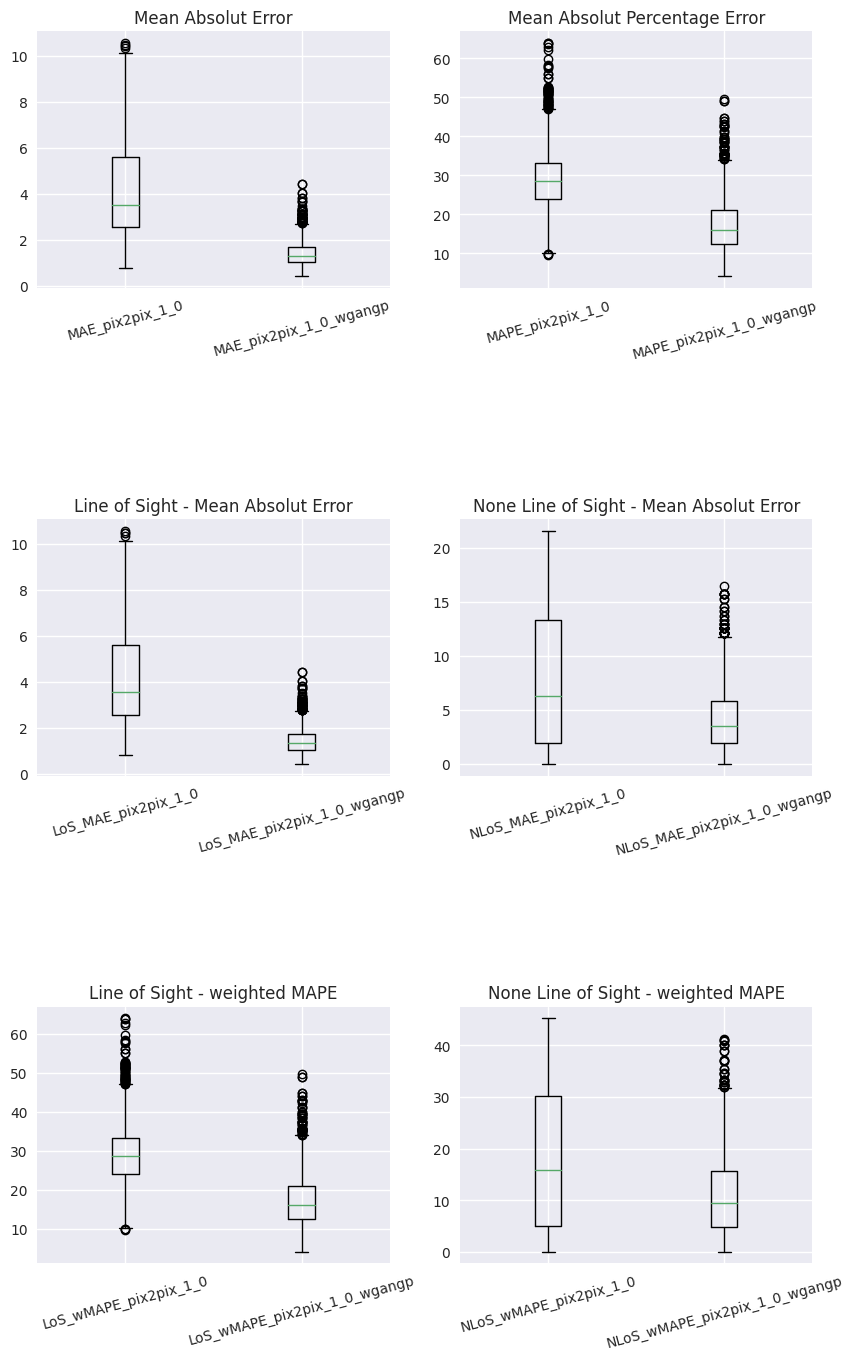

In [181]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 16))
# ax = ax.flatten()

# MEA
values = [merged_df[mae_model_1_name], merged_df[mae_model_2_name]]
names = [mae_model_1_name, mae_model_2_name]
ax[0][0].boxplot(x=values, notch=False)
ax[0][0].set_xticks([1, 2], names)
ax[0][0].set_xticklabels(names, rotation=15)
ax[0][0].set_title("Mean Absolut Error")

# MAPE
values = [merged_df[mape_model_1_name], merged_df[mape_model_2_name]]
names = [mape_model_1_name, mape_model_2_name]
ax[0][1].boxplot(x=values, notch=False)
ax[0][1].set_xticks([1, 2], names)
ax[0][1].set_xticklabels(names, rotation=15)
ax[0][1].set_title("Mean Absolut Percentage Error")

# LoS MEA
values = [merged_df[los_mae_model_1_name], merged_df[los_mae_model_2_name]]
names = [los_mae_model_1_name, los_mae_model_2_name]
ax[1][0].boxplot(x=values, notch=False)
ax[1][0].set_xticks([1, 2], names)
ax[1][0].set_xticklabels(names, rotation=15)
ax[1][0].set_title("Line of Sight - Mean Absolut Error")

# NLoS MEA
values = [merged_df[nlos_mae_model_1_name], merged_df[nlos_mae_model_2_name]]
names = [nlos_mae_model_1_name, nlos_mae_model_2_name]
ax[1][1].boxplot(x=values, notch=False)
ax[1][1].set_xticks([1, 2], names)
ax[1][1].set_xticklabels(names, rotation=15)
ax[1][1].set_title("None Line of Sight - Mean Absolut Error")

# LoS wMAPE
values = [merged_df[los_wmape_model_1_name], merged_df[los_wmape_model_2_name]]
names = [los_wmape_model_1_name, los_wmape_model_2_name]
ax[2][0].boxplot(x=values, notch=False)
ax[2][0].set_xticks([1, 2], names)
ax[2][0].set_xticklabels(names, rotation=15)
ax[2][0].set_title("Line of Sight - weighted MAPE")

# NLoS wMAPE
values = [merged_df[nlos_wmape_model_1_name], merged_df[nlos_wmape_model_2_name]]
names = [nlos_wmape_model_1_name, nlos_wmape_model_2_name]
ax[2][1].boxplot(x=values, notch=False)
ax[2][1].set_xticks([1, 2], names)
ax[2][1].set_xticklabels(names, rotation=15)
ax[2][1].set_title("None Line of Sight - weighted MAPE")

plt.subplots_adjust(hspace=0.9)

print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mae_model_2_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mape_model_2_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_mae_model_2_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_mae_model_2_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_wmape_model_2_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_wmape_model_2_name].mean():>0.2f}")

Example Image

In [182]:
def get_same_pred_real_samples(pred_path:str, real_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            # if len(cur_id) > 1:
            #     raise ValueError("Too many ids found!")
            cur_id = cur_id[0]
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                # if len(cur_id) > 1:
                #     raise ValueError(f"Too many ids found in {cur_image}!")
                if len(cur_id) <= 0:
                    continue
                    # raise ValueError(f"No id found in {cur_image}!")
                cur_id = cur_id[0]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        result_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            # if len(cur_id) > 1:
            #     raise ValueError(f"Too many ids found in {cur_image}!")
            if len(cur_id) <= 0:
                continue
                # raise ValueError(f"No id found in {cur_image}!")
            cur_id = cur_id[0]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    result_samples += [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    return result_samples, ids

/tmp/ipykernel_705276/3844231678.py:14: UserWarning: Overwriting the cmap 'unique_hsv' that was already in the registry.
  plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)


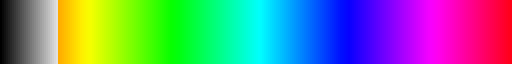

In [183]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if r > 0.99 and g < (170/255):
            gray_value = cur_idx*8 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

# for i in range(256):
#     print([int(cur_color*255) for cur_color in get_cmap('hsv')(i)])

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [184]:
def plot(ax, path, title="", invert=True, sub_image=None, cmap="unique_hsv", scale=False, logscale=False, plot=True):
    img = np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

    if sub_image:
        img_2 = np.array(cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE))
        # img = cv2.subtract(img, img_2)
        img = img - img_2
        img[img < 0] = img[img < 0] * -1
    
    # scaling
    if scale:
        mask = (img > 0) & (img < 160)
        img[mask] = np.clip(img[mask] + 40, 0, 255) # cv2.add(img[mask], 30)

    # invert
    if invert:
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Apply logarithmic scaling to enhance contrast in dim regions
    if logscale:
        img = np.log1p(img)
        # img /= img.max()  # normalize to [0,1]

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap)
        ax.set_title(title)
    
    return img

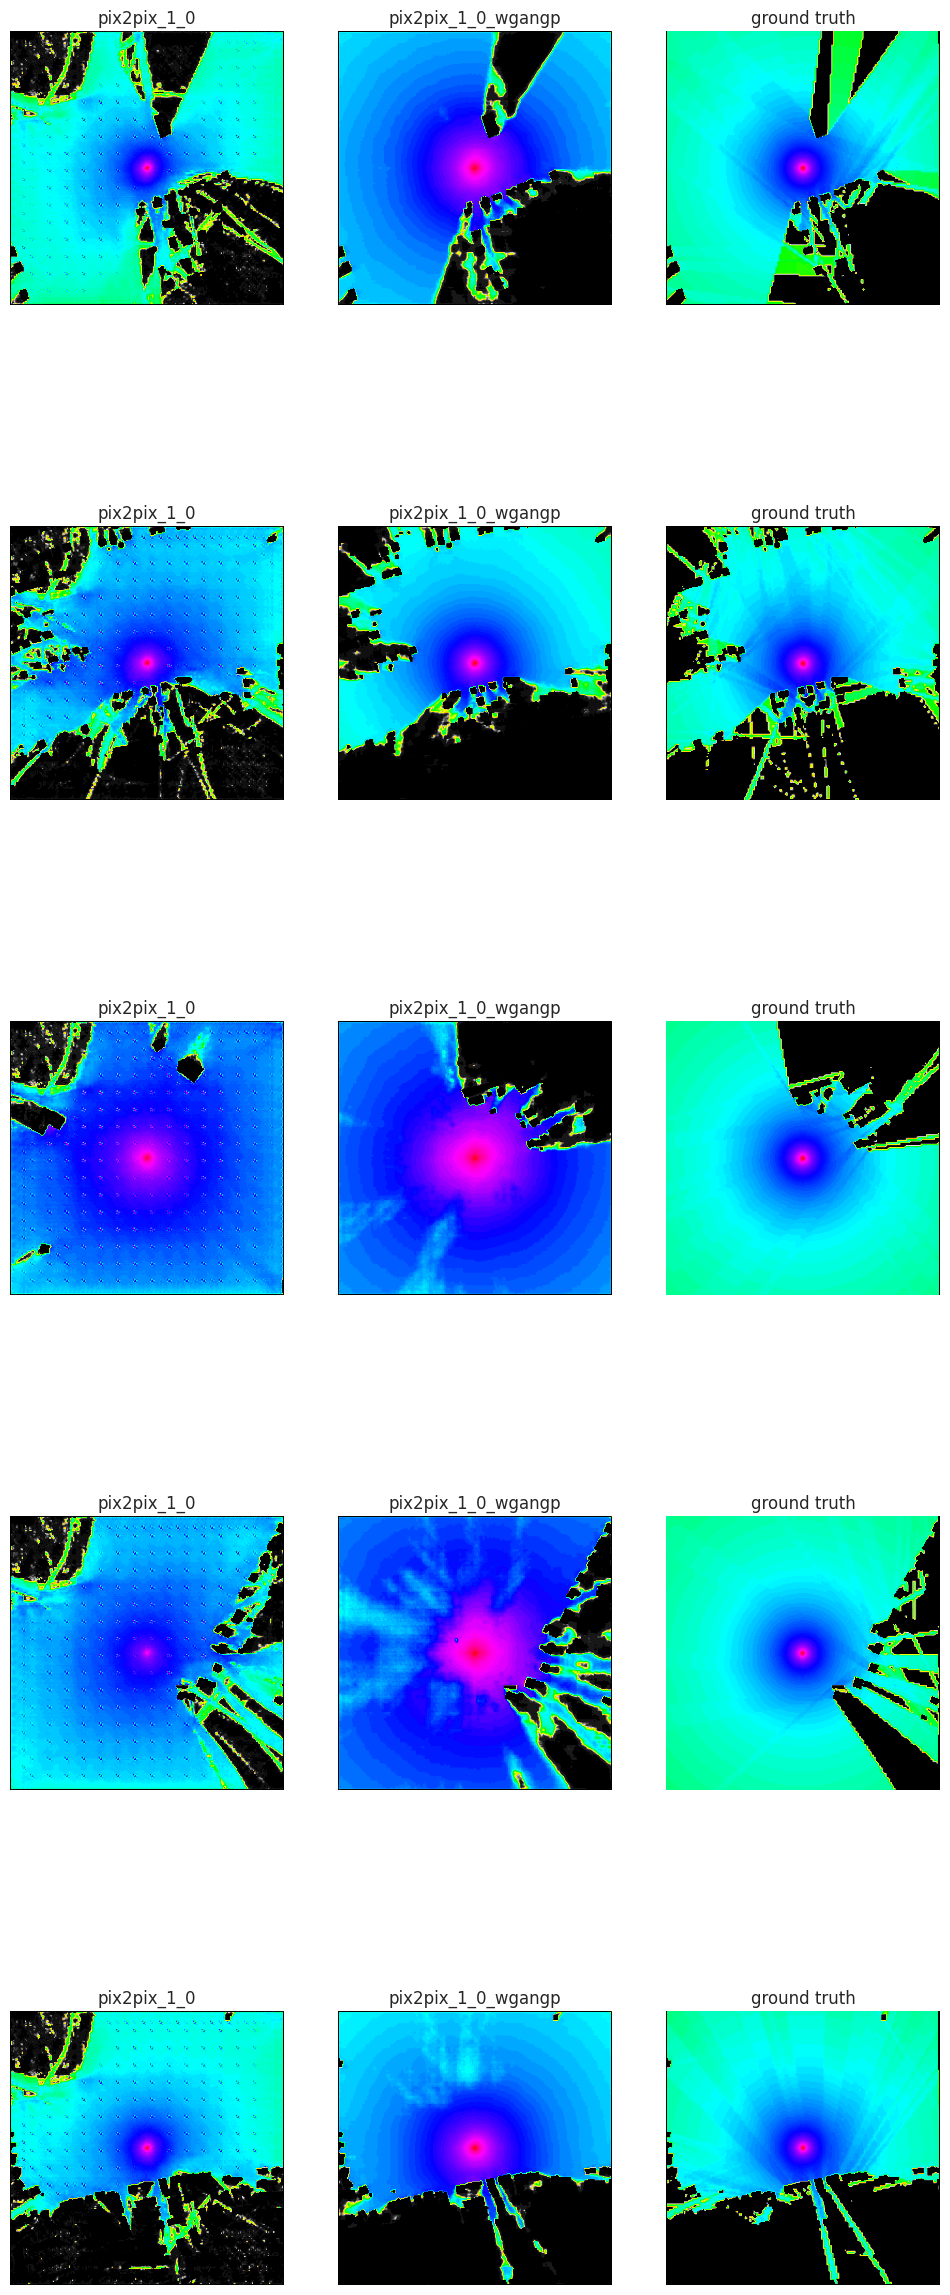

In [198]:
n_samples = 5

example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    n_samples)
example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    n_samples, ids)

pred_model_1 = example_images_model_1[:n_samples]
pred_model_2 = example_images_model_2[:n_samples]
real = example_images_model_2[n_samples:] 

fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(3*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", invert=True)

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", invert=True)

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", invert=True)

plt.subplots_adjust(hspace=0.5)

plt.show();

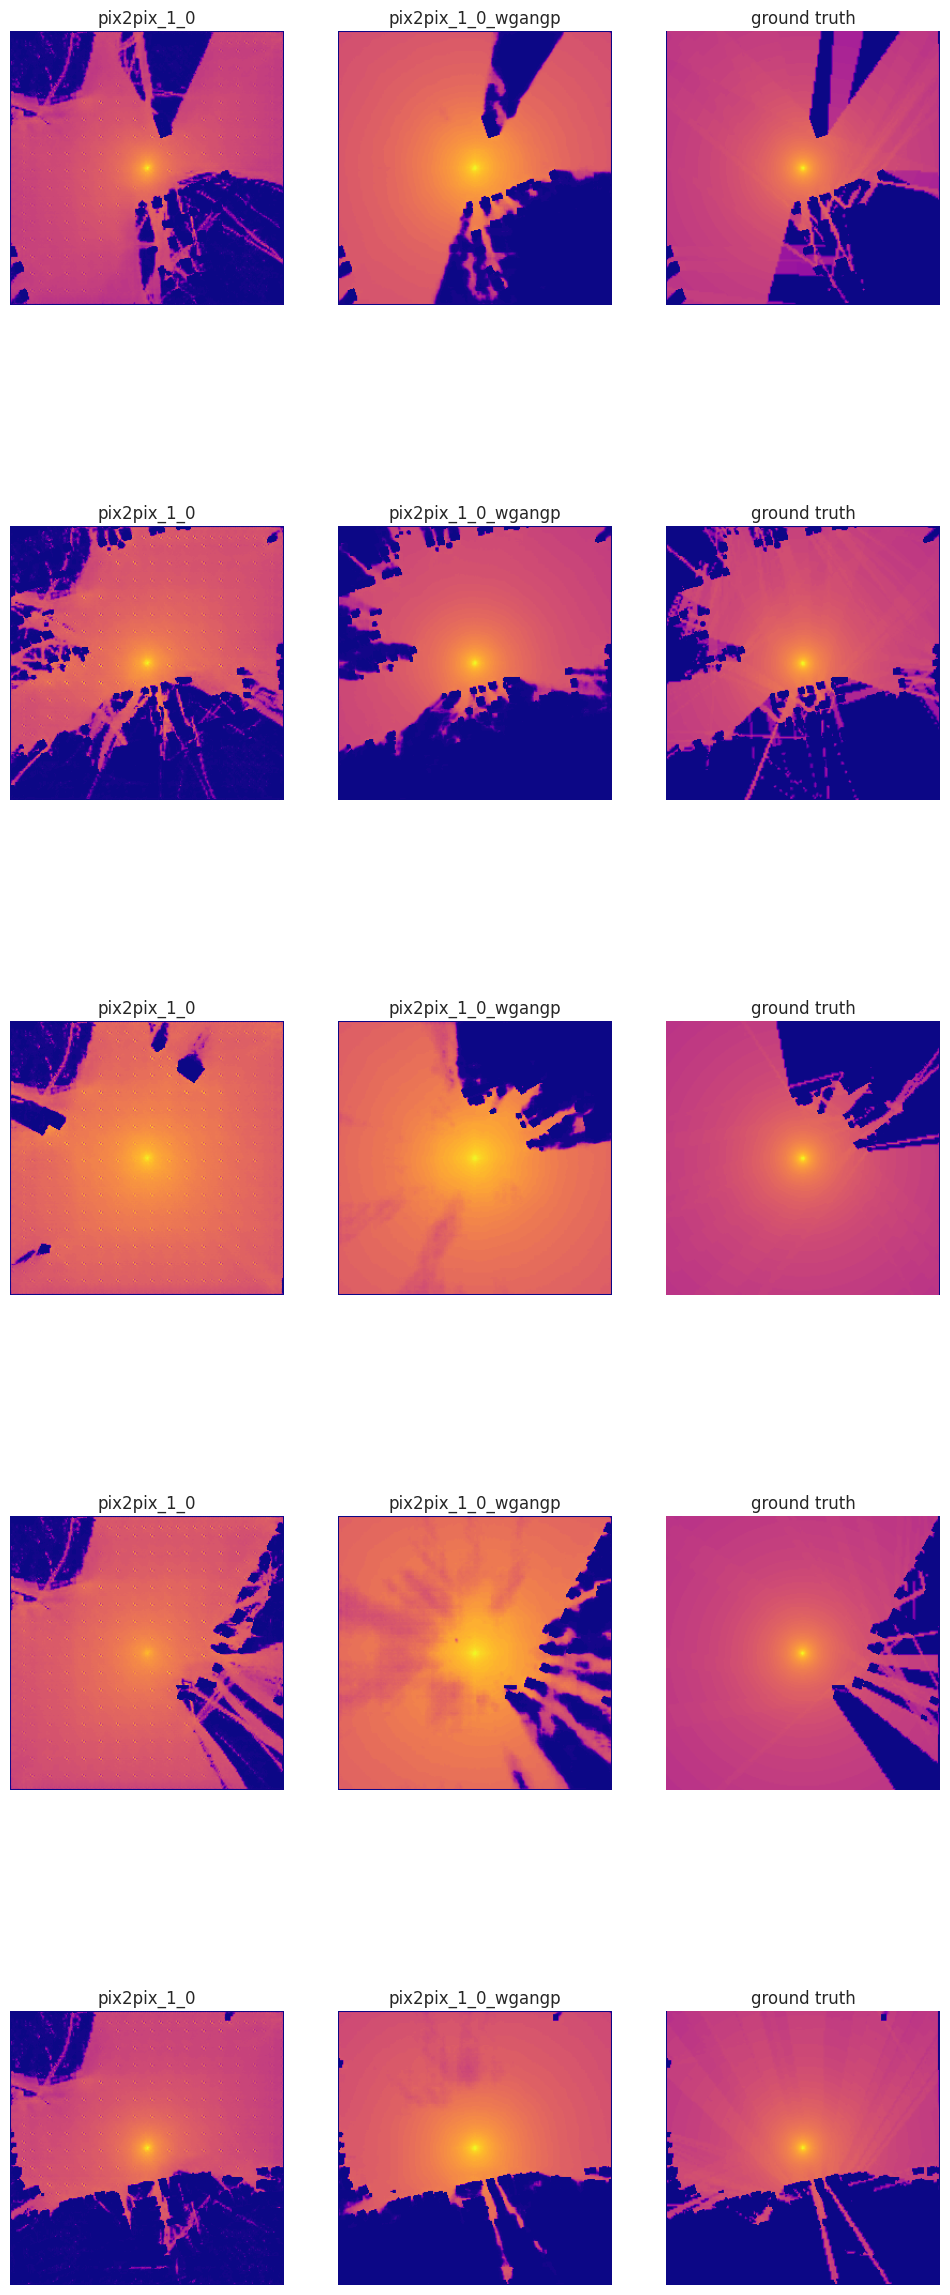

In [199]:
fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(3*4, n_samples*6))

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", invert=True, cmap="plasma")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", invert=True, cmap="plasma")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", invert=True, cmap="plasma")

plt.subplots_adjust(hspace=0.5)

plt.show();

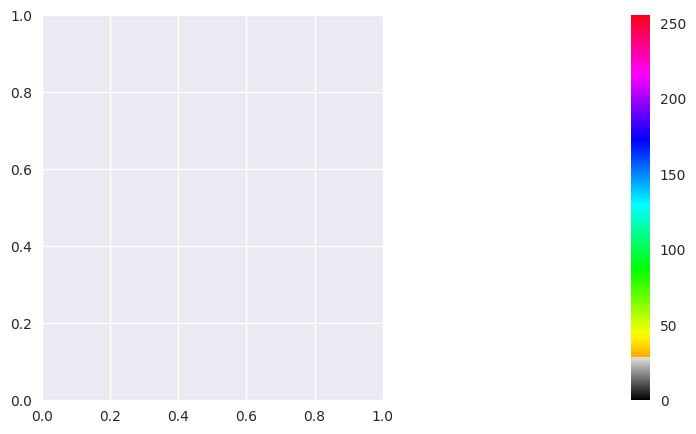

In [200]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="unique_hsv", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

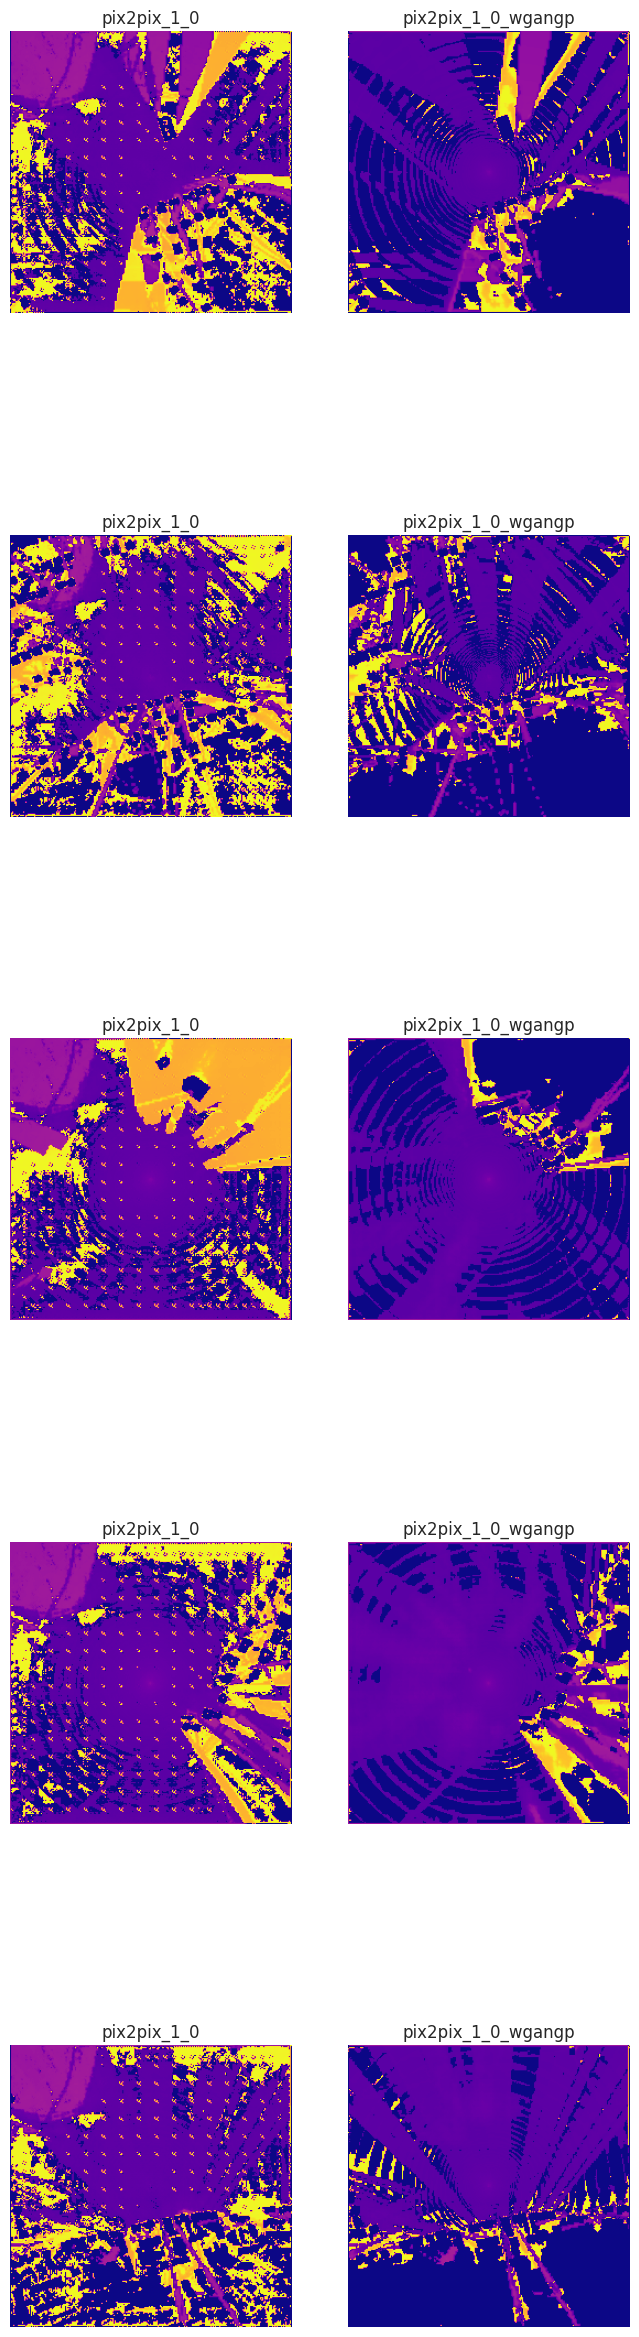

In [201]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", sub_image=real[idx], invert=False, scale=True, cmap="plasma")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", sub_image=real[idx], invert=False, scale=True, cmap="plasma")

plt.subplots_adjust(hspace=0.7)
plt.show();

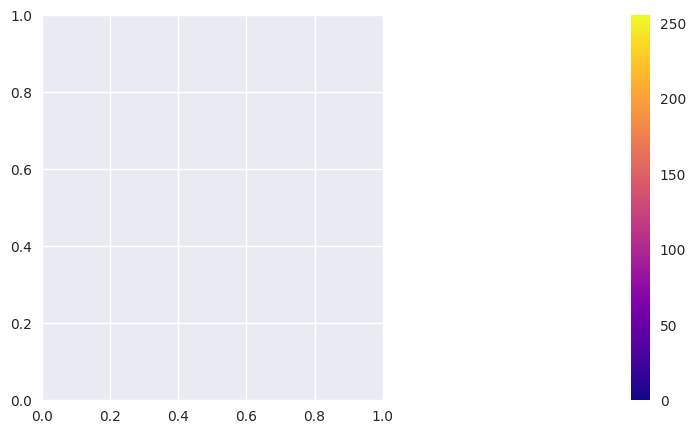

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Create a mappable object (for the colorbar)
norm = plt.Normalize(vmin=0, vmax=255)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])  # Required to set the color range without linking it to any image

fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.4)

plt.show()

Inspect some single images in more detail here:

In [203]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

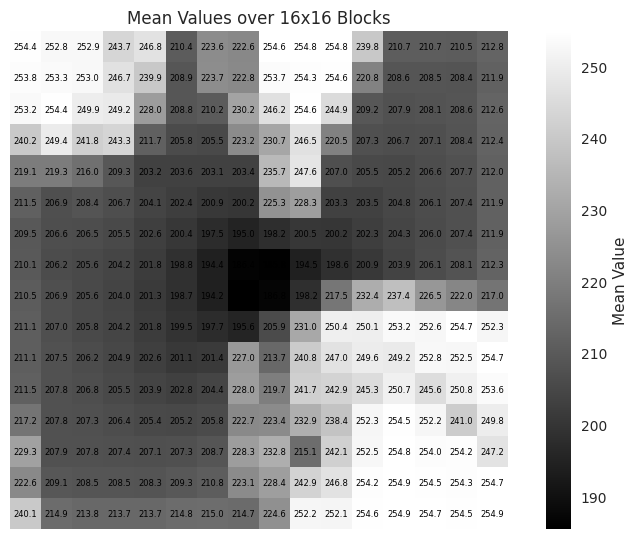

In [204]:
img_path = pred_model_1[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

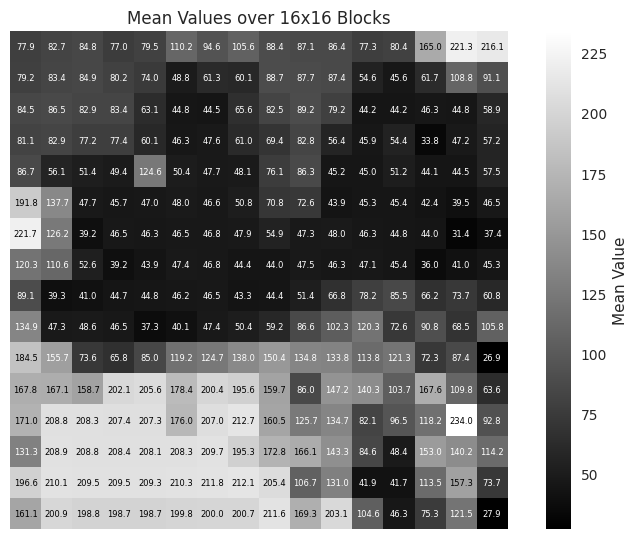

In [205]:
img = plot(None, path=pred_model_1[0], title=f"{model_1}", sub_image=real[idx], invert=False, scale=True, plot=False)
plot_image_with_values(img, block_size=16)

### Old Code /Visualization

Examples from pix2pix_1_0


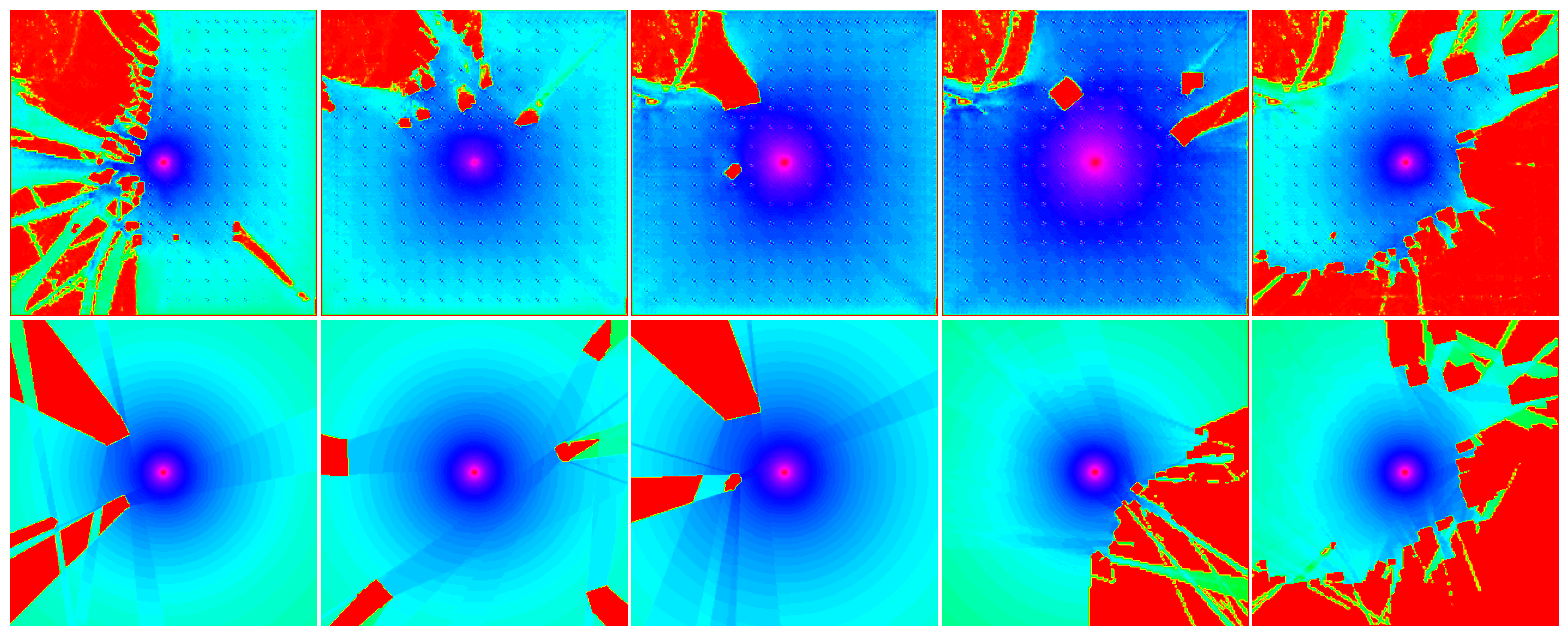

Examples from pix2pix_1_0_wgangp


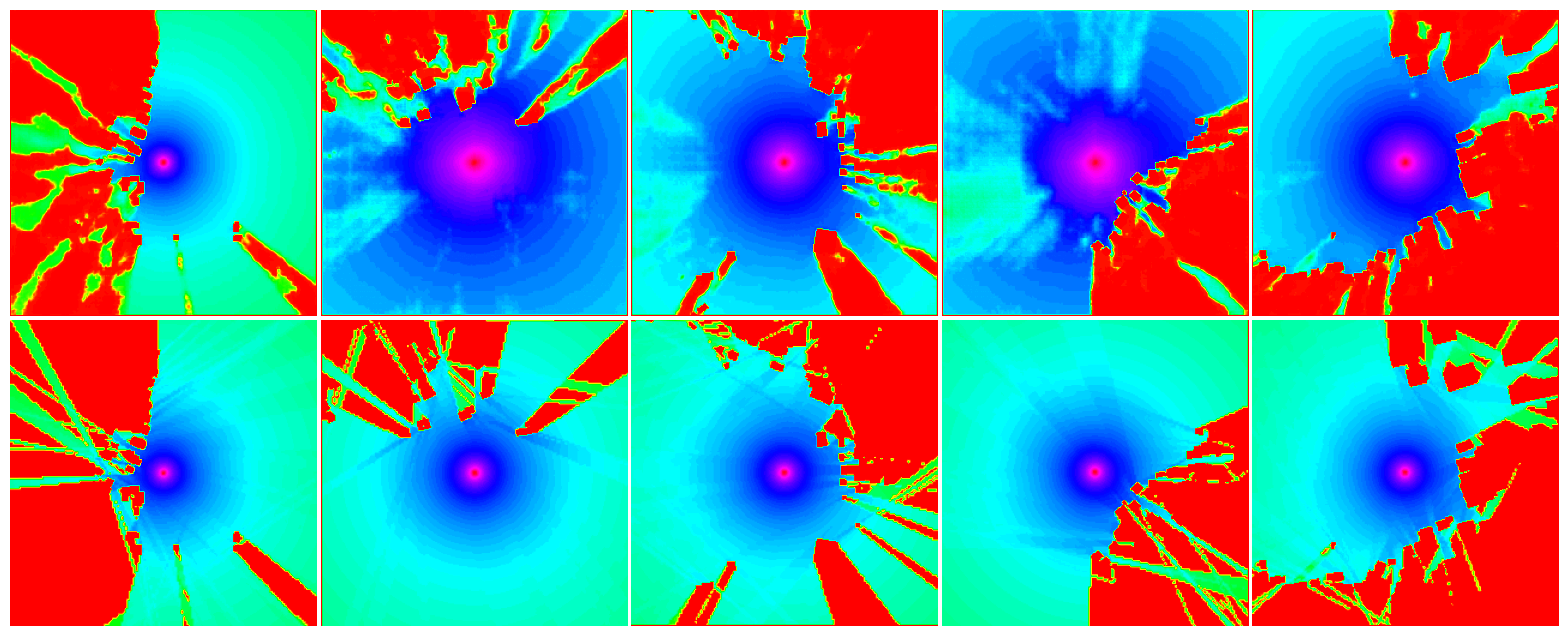

In [206]:
example_images_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                    f"../../data/eval/{model_1}/real",
                                                    5)
print(f"Examples from {model_1}")
show_images(image_paths=example_images_model_1, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

example_images_model_2, _ = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                    f"../../data/eval/{model_2}/real",
                                                    5, ids)
print(f"Examples from {model_2}")
show_images(image_paths=example_images_model_2, 
            image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Examples from pix2pix_1_0


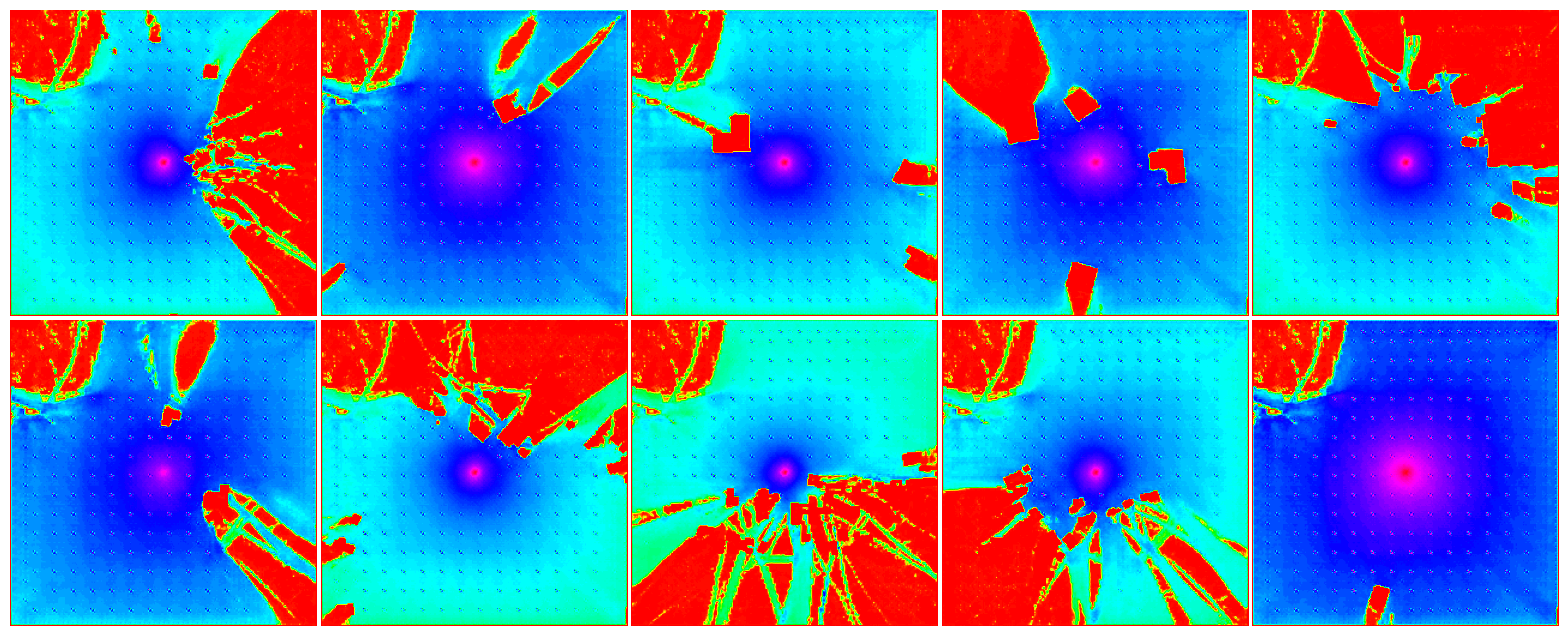

Examples from pix2pix_1_0_wgangp


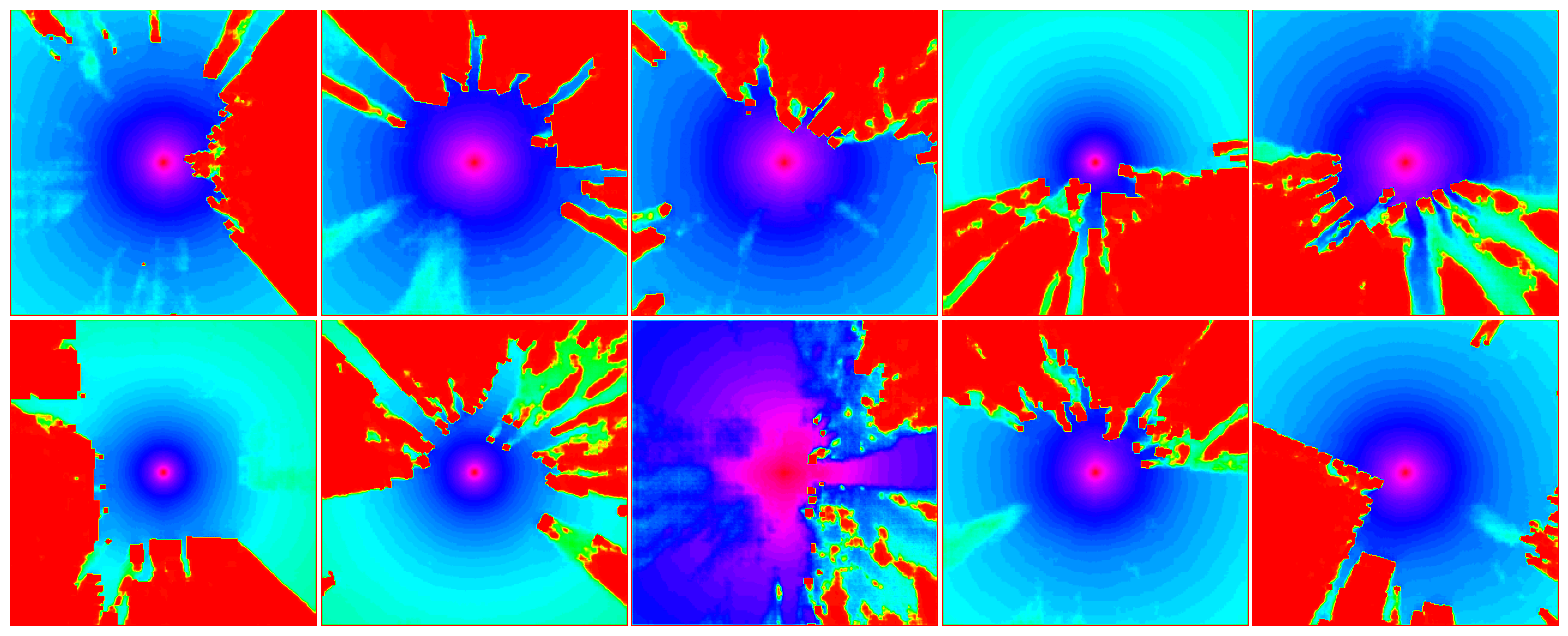

In [207]:
path = f"../../data/eval/{model_1}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_1}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False)

path = f"../../data/eval/{model_2}/pred"
example_images = [os.path.join(path, cur_img) for cur_img in os.listdir(path)]
print(f"Examples from {model_2}")
show_images(image_paths=example_images[:10], image_width=4, cols=5, cmap="hsv", color_space="grey", invert=True, log=False);

Amont of unique values: 85


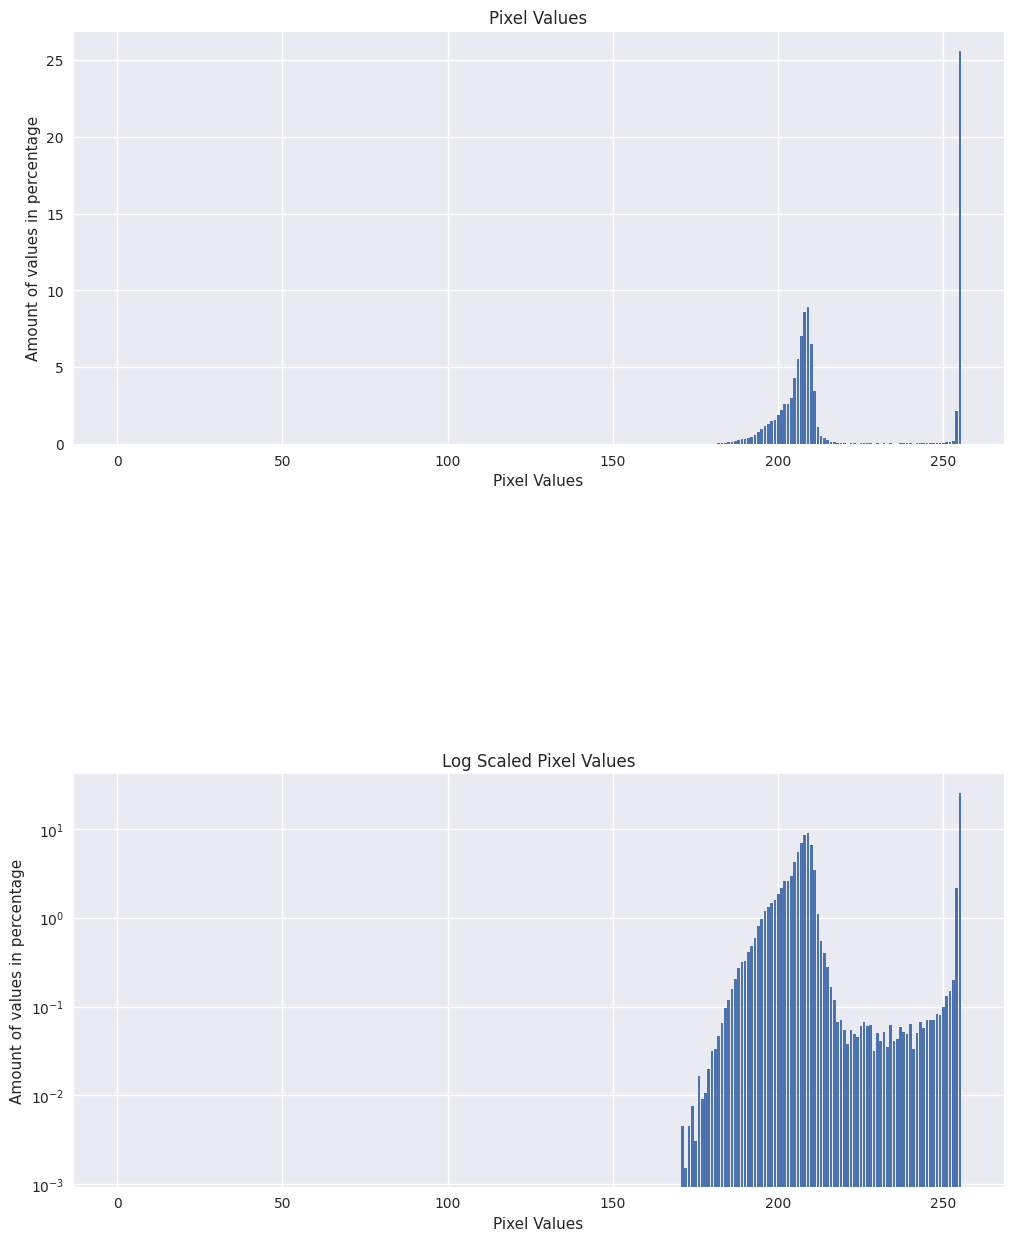

In [208]:
img = cv2.imread(example_images[0], cv2.IMREAD_GRAYSCALE)
unique_values = np.unique(img)
print("Amont of unique values:", len(unique_values))

counts = np.bincount(img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

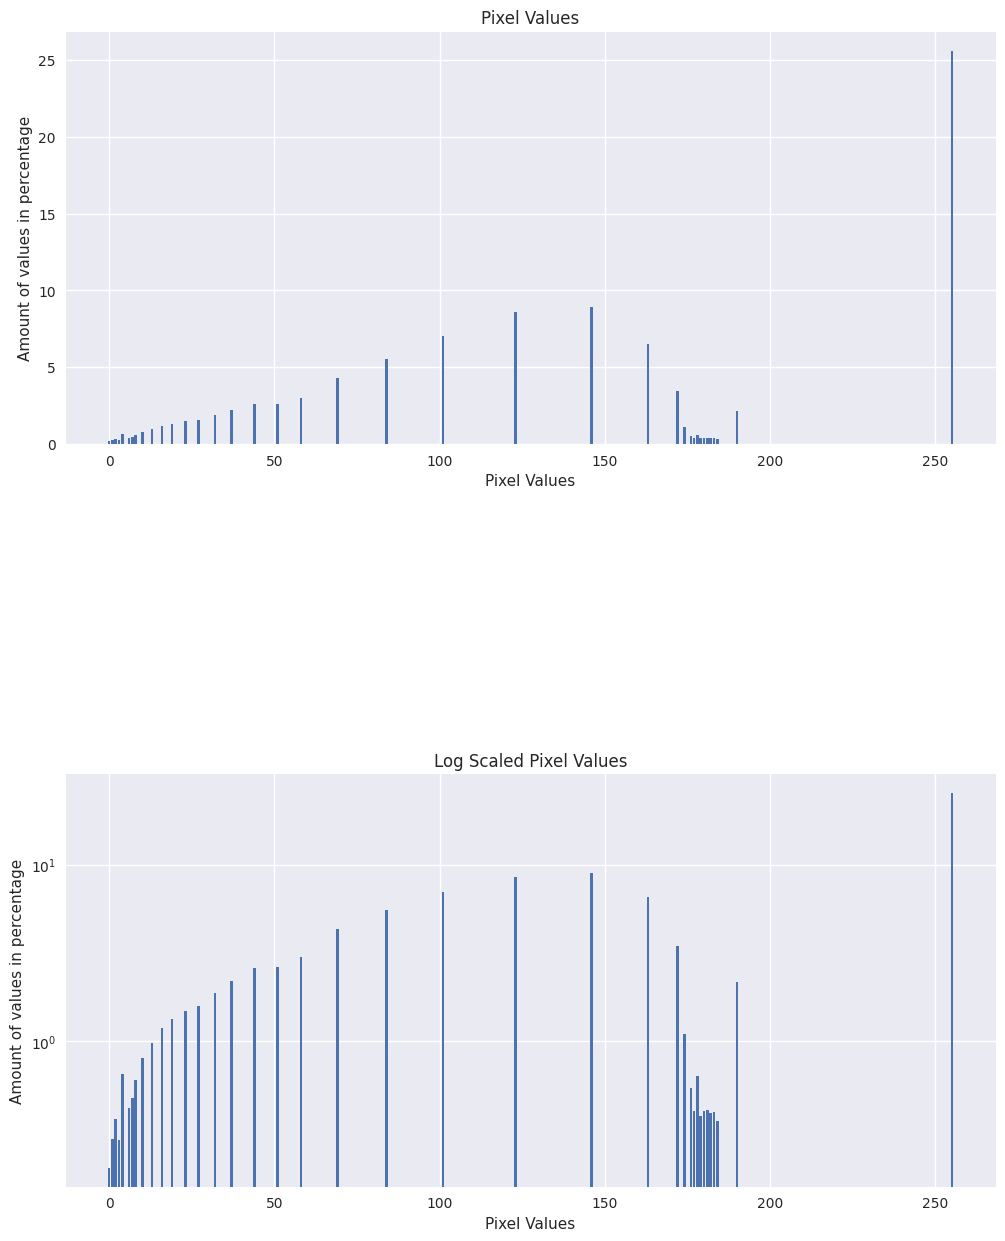

In [209]:
# Apply histogram equalization (clipping values to the range 100-255)
equalized_img = cv2.equalizeHist(img)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);

# # Plot the histogram
# plt.hist(equalized_img.flatten(), bins=256, range=(100, 255), density=True)
# plt.xlabel("Pixel Values")
# plt.ylabel("Frequency")
# plt.show()

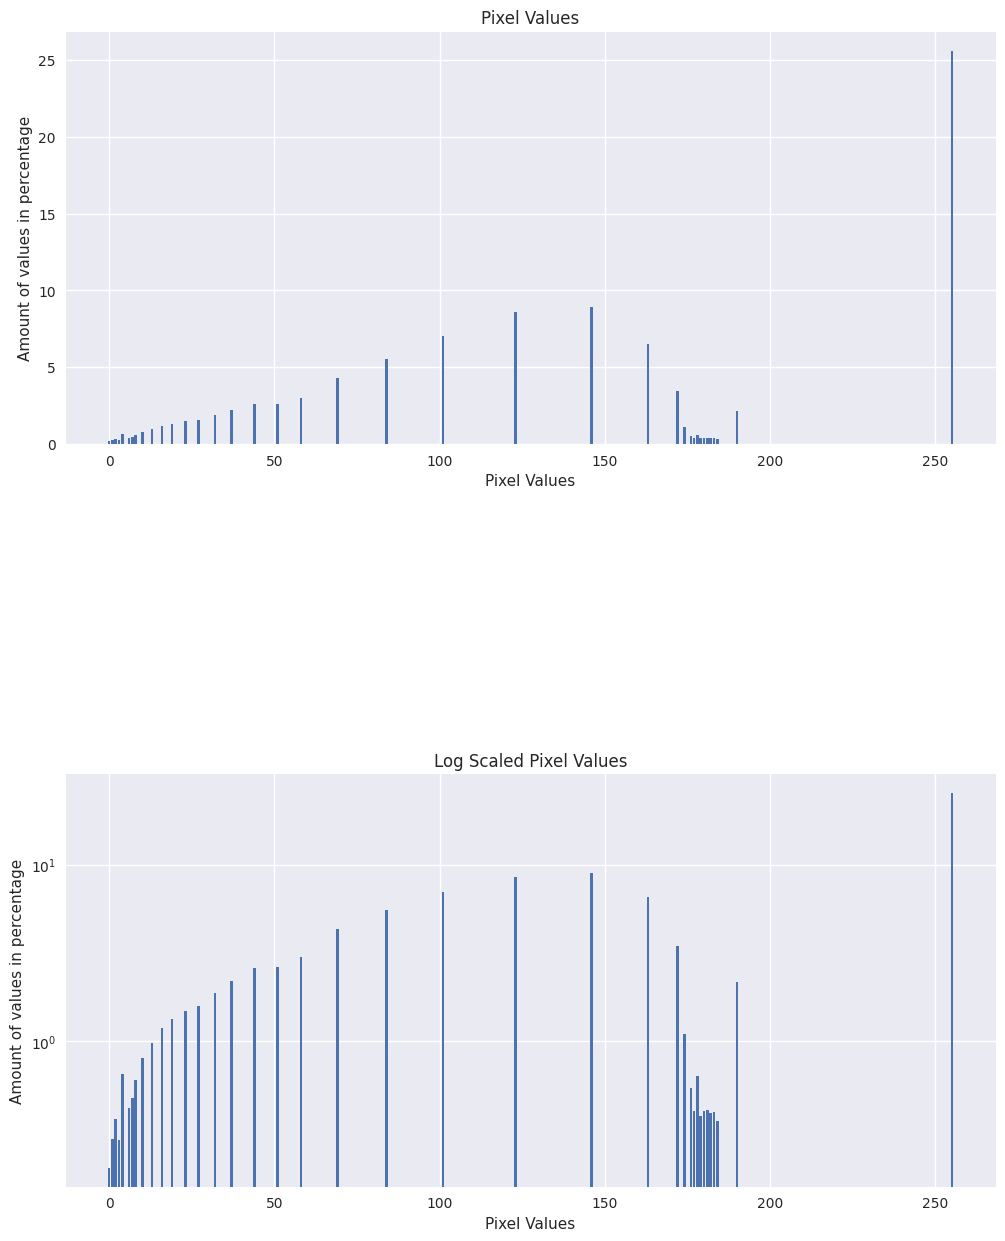

In [210]:
normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
normalized_img = normalized_img * (255)

counts = np.bincount(equalized_img.flatten()).astype(float)
sum_ = np.sum(counts).astype(float)
counts /= sum_
counts *= 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

ax[0].bar(height=counts, x=np.arange(0, 256), orientation='vertical')
ax[0].set_ylabel("Amount of values in percentage")
ax[0].set_xlabel("Pixel Values")
ax[0].set_title("Pixel Values")

ax[1].bar(height=counts, x=np.arange(0, 256), orientation='vertical', log=True)
ax[1].set_ylabel("Amount of values in percentage")
ax[1].set_xlabel("Pixel Values")
ax[1].set_title("Log Scaled Pixel Values")

plt.subplots_adjust(hspace=0.8);